In [1]:
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib as mpl
import pandas as pd

import pickle
import dynchro
from moepy import lowess

In [2]:
%load_ext autoreload
%autoreload 2

# 1. Load data

In [3]:
adata = ad.read_h5ad("figures/wildtype_start.h5ad")

In [4]:
with open("figures/2_dynchro_warpings.pkl", "rb") as f:
    warpings = pickle.load(f)
    warping_irf8, warping_gfi1, warping_both = warpings

    irf8_eryt = warping_irf8[3][0]
    irf8_mono = warping_irf8[3][1]
    irf8_gran = warping_irf8[3][2]

    irf8_eryt = dynchro.tl.avg_cost_path(irf8_eryt, dtw_key="irf8_erythrocytic_irf8")
    irf8_mono = dynchro.tl.avg_cost_path(irf8_mono, dtw_key="irf8_monocytic_irf8")
    irf8_gran = dynchro.tl.avg_cost_path(irf8_gran, dtw_key="irf8_granulocytic_irf8")

    gfi1_eryt = warping_gfi1[3][0]
    gfi1_mono = warping_gfi1[3][1]
    gfi1_gran = warping_gfi1[3][2]

    gfi1_eryt = dynchro.tl.avg_cost_path(gfi1_eryt, dtw_key="gfi1_erythrocytic_gfi1")
    gfi1_mono = dynchro.tl.avg_cost_path(gfi1_mono, dtw_key="gfi1_monocytic_gfi1")
    gfi1_gran = dynchro.tl.avg_cost_path(gfi1_gran, dtw_key="gfi1_granulocytic_gfi1")

    def calculate_lowess(adata, dtw_key = "dtw", pseudotime_key="norm_pseudotime"):
        average_cost = adata.obs.sort_values(pseudotime_key)[f"{dtw_key}_avg_cost"].values
        xvals = adata.obs.sort_values(pseudotime_key)[pseudotime_key].values

        quant_reg_func = lowess.calc_quant_reg_betas
        quantile_model = lowess.Lowess(reg_func=quant_reg_func)

        quantile_model.fit(xvals, average_cost, frac=0.3)
        x_pred = np.linspace(xvals.min(), xvals.max(), 100)
        y_pred = quantile_model.predict(x_pred)

        df_quantiles = lowess.quantile_model(xvals, average_cost, frac=0.3, num_fits=100)

        return xvals, x_pred, y_pred, df_quantiles, average_cost

    def norm(x):
        return (x - x.min()) / (x.max() - x.min())

    irf8_mono.obs["norm_pseudotime"] = norm(irf8_mono.obs["pseudotime"])
    irf8_gran.obs["norm_pseudotime"] = norm(irf8_gran.obs["pseudotime"])
    gfi1_mono.obs["norm_pseudotime"] = norm(gfi1_mono.obs["pseudotime"])
    gfi1_gran.obs["norm_pseudotime"] = norm(gfi1_gran.obs["pseudotime"])

    # calculate lowess smoothing here
    lowess_irf8_mono = calculate_lowess(irf8_mono, dtw_key="irf8_monocytic_irf8", pseudotime_key="norm_pseudotime")
    lowess_irf8_gran = calculate_lowess(irf8_gran, dtw_key="irf8_granulocytic_irf8", pseudotime_key="norm_pseudotime")
    lowess_gfi1_mono = calculate_lowess(gfi1_mono, dtw_key="gfi1_monocytic_gfi1", pseudotime_key="norm_pseudotime")
    lowess_gfi1_gran = calculate_lowess(gfi1_gran, dtw_key="gfi1_granulocytic_gfi1", pseudotime_key="norm_pseudotime")

defaultdict(<class 'list'>, {'Lsk.65': np.float64(87.17672929094589), 'Lsk.26': np.float64(89.82330380448286), 'Lsk.31': np.float64(87.06766074553957), 'Lsk.50': np.float64(89.74449298700807), 'Lsk.49': np.float64(89.01658438458493), 'Lsk.63': np.float64(88.99537566298052), 'Lsk.80': np.float64(91.33858663843404), 'Lsk.78': np.float64(94.18047506897146), 'Lsk.24': np.float64(90.40758737136525), 'Lsk.22': np.float64(85.86937347683313), 'Lsk.17': np.float64(80.51407165580154), 'Lsk.18': np.float64(86.70384094416579), 'Lsk.88': np.float64(89.64488416342664), 'Lsk.51': np.float64(85.3079571706331), 'Lsk.73': np.float64(88.07672029009757), 'Lsk.16': np.float64(80.7644237511982), 'Lsk.81': np.float64(87.92177445809205), 'Lsk.43': np.float64(88.40143960193535), 'Lsk.89': np.float64(96.80579920376202), 'Lsk.44': np.float64(99.88090119680098), 'Lsk.85': np.float64(94.23307659642614), 'Lsk.4': np.float64(96.50321034942716), 'Lsk.27': np.float64(94.12726425514356), 'Cmp.32': np.float64(90.1283031

100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


In [5]:
with open("figures/2_dynchro_warpings_warpedfig_irf8.pkl", "rb") as f:
    warped_irf8, irf8_erythrocytic, irf8_monocytic, irf8_granulocytic = pickle.load(f)

with open("figures/2_dynchro_warpings_warpedfig_gfi1.pkl", "rb") as f:
    warped_gfi1, gfi1_erythrocytic, gfi1_monocytic, gfi1_granulocytic = pickle.load(f)

In [6]:
with open("figures/2_dynchro_bootstrap_results.pkl", "rb") as f:
    res_irf8, res_gfi1, res_both = pickle.load(f)

# 2. Plotting functions

In [15]:
def get_colors(colors, labels):
    color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    handles, labels = get_color_legend(color_map)

    return translated_colors, handles, labels

def get_color_legend(color_map):
    handles = [
        plt.Line2D(
                [0], [0], marker='o', markerfacecolor=c, color = "k", 
                markersize = 7.5, lw = 0
            ) for c in color_map.values()
        ]
    labels = list(color_map.keys())
    return handles, labels

def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list

In [7]:
def plot_celltypes(adata, axes):
    xs = adata.obsm['X_dr'][:, 0]
    ys = adata.obsm['X_dr'][:, 1]
    labels = adata.obs['label'].values

    translated_colors, handles, labels = get_colors(colors, labels)

    ax = axes[0]

    ax.scatter(xs, ys, c=translated_colors,  s=60, edgecolors = 'k')

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_xlabel("Flat tree plot", fontdict={'fontsize': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.15, 0.1)
    ax.set_ylabel("")

    # ax.set_xlabel("Flat tree plot")
    # ax.xaxis.set_label_coords(0.25, 0.95)
    
    axes[1].axis('off')

    axes[1].legend(handles=handles, labels=labels, title="", loc='upper center', frameon=False, fontsize="x-small", title_fontsize="small")
    
    return ax

In [8]:
def plot_pseudotime(adata, axes, title):

    xs = adata.obsm['X_dr'][:, 0]
    ys = adata.obsm['X_dr'][:, 1]
    colors = adata.obs['pseudotime'].values
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())

    tints = ["#69BAEF", "#80C2F1", "#95CBF3", "#A9D3F5", "#BBDCF7", "#CDE5F9", "#DEEDFB", "#EEF6FD", "#FFFFFF"]
    shades = ["#4DA2D5", "#2C8ABC", "#0073A3", "#005D8B", "#004774"][::-1]
    blues = shades +tints

    palette = clr.LinearSegmentedColormap.from_list("custom", blues, N=256)

    ax = axes[0]
    ax.scatter(xs, ys, c=norm_colors, cmap=palette, s=100, edgecolors = 'k')

    cmap = clr.LinearSegmentedColormap.from_list("custom", blues, N=256)
    norm = clr.Normalize(vmin=0, vmax=1)

    axes[1].axis('off')

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=axes[1], orientation='vertical', label='Pseudotime',
                fraction=0.75, shrink=0.75, ticks=[0, 1])

    ax.set_title(title)

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_xlabel("Flat tree plot")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.25, 0.95)
    ax.set_ylabel("")

In [9]:
def plot_avg_cost(lowess_arg, title, color, ax, removedspines=['top', 'right', 'bottom', 'left']):
    pt, x, y, quantile_df, avg_cost = lowess_arg

    ax.plot(x, y, color='black', linestyle='-', label='Trend Line (LOWESS)')
    ax.fill_between(quantile_df.index, quantile_df[0.1], quantile_df[0.9], color=colors[0], edgecolor='face', linewidth=0, alpha=0.25, label='10-90% Prediction Interval')
    ax.scatter(pt, avg_cost, label="Average Cost Path", color=color, alpha=1, edgecolors='k')

    # trendline
    b, a = np.polyfit(x, y, 1)
    ax.plot(x, a + b * x, color='grey', linestyle='--', label='Trend Line (Linear Fit)')

    # ax.scatter(data.obs.sort
    # dynchro.pl.plot_avg_cost_path(data, pseudotime_key="norm_pseudotime", dtw_key=dtw_key, color=color, ax=ax)
    if removedspines is not None:
        ax.spines[removedspines].set_visible(False)
    # ax.get_legend().remove()
    ax.set_title("")
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

In [10]:
def plot_warping(
        warped_datasets,
        extra_datasets = None,
        pseudotime_key: str = "pseudotime",
        dtw_key: str = "dtw",
        dimred_key: str = "X_umap",
        yshift = 0,
        ax = None,
        colors = None
):
# fix legends as well
    if ax is None:
        fig, ax = plt.subplots(figsize=(10.1, 3))

    # check only two warped datasets are provided
    assert  len(warped_datasets) <= 2, "Only two warped datasets are supported for plotting."

    # colors = ["#ff681c", "#1b2944", "#3abbba", "#315b25"]
    # colors = ['#6fa8dc','#93c47d','#ffc000','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']
    # colors = [ "#EF7269", "#EFCB69", "#69EF72",  "#69BAEF", "#7269EF", "#CB69EF"]
    datasets = extra_datasets + warped_datasets if extra_datasets else warped_datasets
    colors = colors[2:] + colors[:2]

    yshifts = [0, 0, yshift, 0]
    # print(yshifts)
    for dataset, color, yshift_ in zip(datasets, colors, yshifts):
        # print(ift_)
        dimred = dataset.obsm[dimred_key]
        pseudotime = norm(dataset.obs[pseudotime_key])
        ax.scatter(pseudotime, dimred[:, 1] + yshift_, c=color, edgecolors="black", linewidths=1.1, s=60)

    warping1 = flatten(warped_datasets[0].obs[f"{dtw_key}_path"])
    warping2 = flatten(warped_datasets[1].obs[f"{dtw_key}_path"])

    ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
    ds1_y = warped_datasets[0].obsm[dimred_key][warping2, 1] + yshifts[2]
    ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
    ds2_y = warped_datasets[1].obsm[dimred_key][warping1, 1]

    for x1, y1, x2, y2 in zip(ds1_x, ds1_y, ds2_x, ds2_y):
        ax.plot([x1, x2], [y1, y2], color='grey', alpha = 0.2)

    ax.legend()

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.annotate("", xytext=(x0, y0), xy=(0.2, y0),
            arrowprops=dict(arrowstyle="->"))

    # ax.arrow(x0, y0 - 2, 0.2, 0, head_width=0.5, head_length=0.02, fc='k', ec='k')

    ax.set_xlabel("Pseudotime", fontdict={'fontsize': 8}, color='k')
    ax.xaxis.set_label_coords(0.055, 0.07)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend()

    return ax


In [11]:
def plot_violins(data, ax, label1, label2, label3, pos1, pos2, pos3):
    parts = ax.violinplot(data, showextrema = False)

    violin_colors = [
        colors[0],
        colors[1],
        colors[6]
    ]
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["Erythroid", "Monocytic", "Granulocytic"])
    ax.set_yticks([1.9, 1.7, 1.5, 1.3, 1.1, 0.9])
    ax.set_ylabel("")

    ax.annotate(label1, xy=(1.5, pos1), xytext=(1.5, pos1 + 0.01),
            fontsize=8, ha='center', va='bottom', xycoords='data', 
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1.0))

    ax.annotate(label2, xy=(2, pos2), xytext=(2, pos2 + 0.01),
                fontsize=8, ha='center', va='bottom', xycoords='data', 
                arrowprops=dict(arrowstyle='-[, widthB=10, lengthB=.3', lw=1.0))
    ax.annotate(label3, xy=(2.5, pos3), xytext=(2.5, pos3 + 0.01),
                fontsize=8, ha='center', va='bottom', xycoords='data', 
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1.0))

# 3. Final plot

/tmp/ipykernel_817837/2076186523.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)
/tmp/ipykernel_817837/3188753739.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pseudotime, dimred[:, 1] + yshift_, c=color, edgecolors="black", linewidths=1.1, s=60)
/tmp/ipykernel_817837/3188753739.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

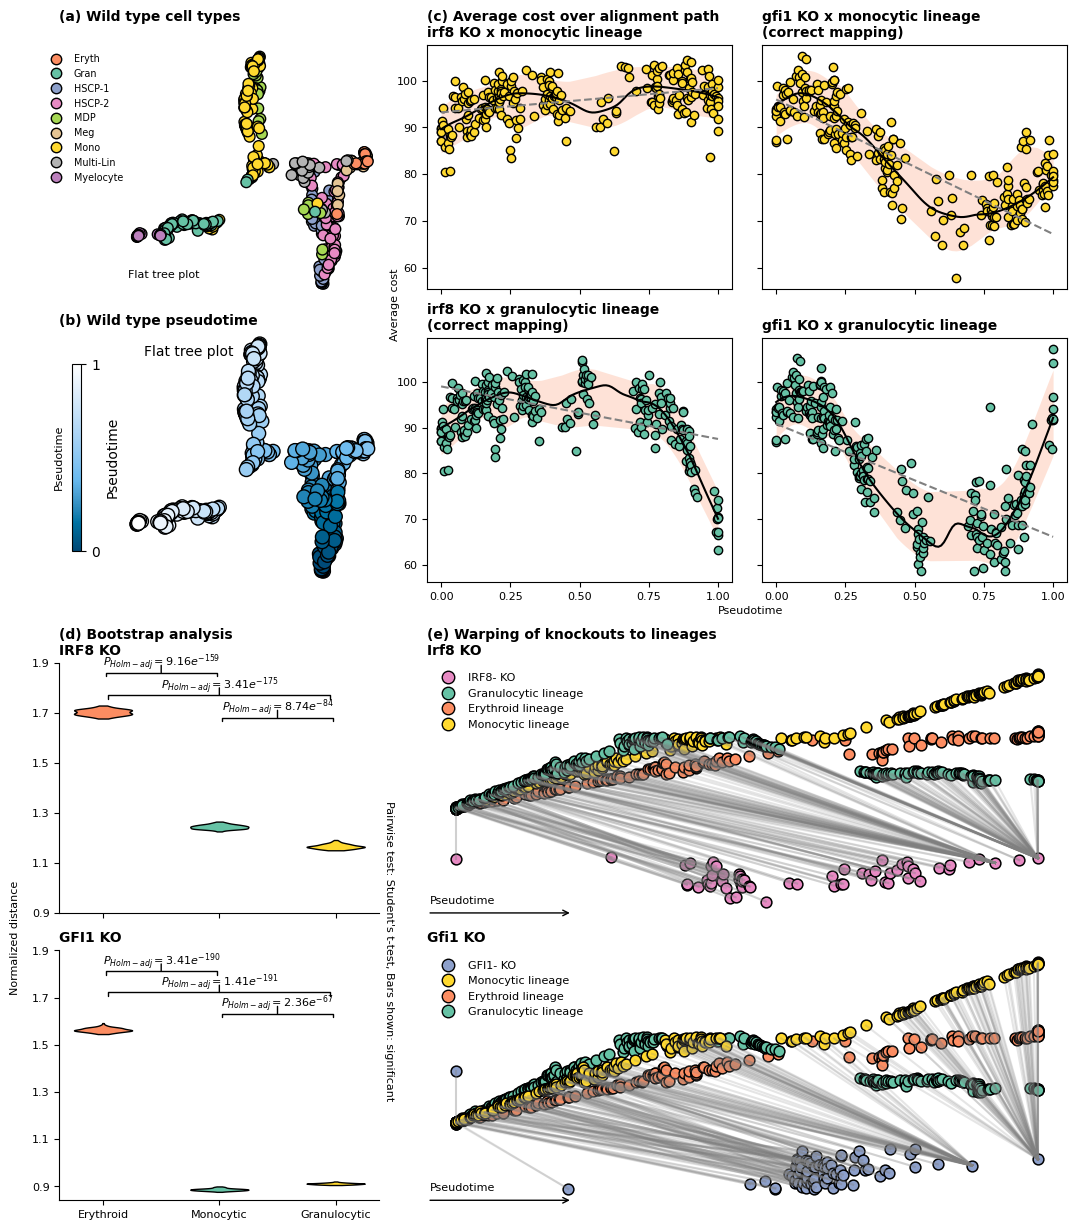

In [16]:
colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)
colors = [colors[1]] + [colors[0]] + list(colors[2:5]) + [colors[6]] + [colors[5]] + list(colors[7:])

# Plot setup

fig = plt.figure(figsize=(13, 15))
gs_outer = fig.add_gridspec(2, 2, width_ratios = [1,2])

gsa = gs_outer[0, 0].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)
gsb = gs_outer[0, 1].subgridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0.2)
gsc = gs_outer[1, 0].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)
gsd = gs_outer[1, 1].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)

gsa1 = gsa[0, 0].subgridspec(1, 2, width_ratios=[2, 10])
gsa2 = gsa[1, 0].subgridspec(1, 2, width_ratios=[2, 10])

axa11 = fig.add_subplot(gsa1[0, 0])
axa12 = fig.add_subplot(gsa1[0, 1])
axa21 = fig.add_subplot(gsa2[0, 0])
axa22 = fig.add_subplot(gsa2[0, 1])

# cell type plots
plot_celltypes(adata, [axa12, axa11])
axa11.set_title("(a) Wild type cell types\n", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
plot_pseudotime(adata, [axa22, axa21], "")
axa21.set_title("(b) Wild type pseudotime", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axa21.text(-0.5, 0.5, "Pseudotime", fontsize=8, ha='left', va='center', rotation = 90)

# average cost plots
(axb1, axb2), (axb3, axb4) = gsb.subplots(sharex='col', sharey='row')

plot_avg_cost(lowess_irf8_mono, "irf8 KO to monocytic lineage", colors[6], axb1, removedspines=None)
plot_avg_cost(lowess_irf8_gran, "irf8 KO to granulocytic lineage", colors[1], axb3, removedspines=None)
plot_avg_cost(lowess_gfi1_mono, "gfi1 KO to monocytic lineage", colors[6], axb2, removedspines=None)
plot_avg_cost(lowess_gfi1_gran, "gfi1 KO to granulocytic lineage", colors[1], axb4, removedspines=None)

# plt.subplots_adjust(top=0.7)
axb1.set_title("(c) Average cost over alignment path\nirf8 KO x monocytic lineage", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axb2.set_title("gfi1 KO x monocytic lineage\n(correct mapping)", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axb3.set_title("irf8 KO x granulocytic lineage\n(correct mapping)", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axb4.set_title("gfi1 KO x granulocytic lineage", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

axb1.set_xticks([0, 0.25, 0.5, 0.75, 1])
axb2.set_xticks([0, 0.25, 0.5, 0.75, 1])

yticks = [60, 70, 80, 90, 100]
axb1.set_yticks(yticks)
axb3.set_yticks(yticks)

axb1.tick_params(axis='both', which='major', labelsize=8)
axb2.tick_params(axis='both', which='major', labelsize=8)
axb3.tick_params(axis='both', which='major', labelsize=8)
axb4.tick_params(axis='both', which='major', labelsize=8)

axb1.text(-0.15, 60, "Average cost", fontsize=8, ha='right', va='top', rotation = 90)
axb3.text(1, 50, "Pseudotime", fontsize=8, ha='left', va='center')


plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.15)

axc1 = fig.add_subplot(gsc[0, 0])
axc2 = fig.add_subplot(gsc[1, 0])

gsd1 = gsd[0, 0].subgridspec(1, 1)
gsd2 = gsd[1, 0].subgridspec(1, 1)

axd11 = fig.add_subplot(gsd1[0, 0])
# axd12 = fig.add_subplot(gsd1[0, 1])
axd21 = fig.add_subplot(gsd2[0, 0])
# axd22 = fig.add_subplot(gsd2[0, 1])

lineage_colors = {
    "Erythroid\nlineage": colors[0],
    "Monocytic\nlineage": colors[6],
    "Granulocytic\nlineage": colors[1],
    "IRF8- KO": colors[3],
    "GFI1- KO": colors[2],
}

lineage_colors = {
    "ery": (colors[0], "Erythroid lineage"),
    "mono": (colors[6], "Monocytic lineage"),
    "gran": (colors[1], "Granulocytic lineage"),
    "irf8": (colors[3], "IRF8- KO"),
    "gfi1": (colors[2], "GFI1- KO"),
}

colors_irf8 = [
    lineage_colors["irf8"],
    lineage_colors["gran"],
    lineage_colors["ery"], 
    lineage_colors["mono"]
]

plot_warping(
    warped_datasets = [warped_irf8, irf8_granulocytic],
    extra_datasets = [irf8_erythrocytic, irf8_monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap",
    yshift = -15,
    ax=axd11,
    colors = [x[0] for x in colors_irf8]
)
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c[0], color = "k", markersize = 9, lw = 0) for c in colors_irf8]
labels = [x[1] for x in colors_irf8]

axd11.legend(
    handles=handles, labels=labels, frameon=False, loc='upper left', fontsize=8
)

axd11.set_title("(e) Warping of knockouts to lineages\nIrf8 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axd21.set_title("Gfi1 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

colors_gfi1 = [
    lineage_colors["gfi1"],
    lineage_colors["mono"],
    lineage_colors["ery"],
    lineage_colors["gran"]
]

plot_warping(
    warped_datasets = [warped_gfi1, gfi1_monocytic],
    extra_datasets = [gfi1_erythrocytic, gfi1_granulocytic],
    dtw_key = "gfi1_monocytic_gfi1",
    dimred_key = "X_vis_umap",
    yshift = -8,
    ax=axd21,
    colors = [x[0] for x in colors_gfi1]
)

handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c[0], color = "k", markersize = 9, lw = 0) for c in colors_gfi1]
labels = [x[1] for x in colors_gfi1]

axd21.legend(
    handles=handles, labels=labels, frameon=False, loc='upper left', fontsize=8
)

data_irf8 = pd.DataFrame({
    "ery": res_irf8[0],
    "mono": res_irf8[1],
    "gran": res_irf8[2]
})

data_gfi1 = pd.DataFrame({
    "ery": res_gfi1[0],
    "mono": res_gfi1[1],
    "gran": res_gfi1[2]
})

label1 = '$P_{Holm-adj}=9.16e^{-159}$'
label2 = '$P_{Holm-adj}=3.41e^{-175}$'
label3 = '$P_{Holm-adj}=8.74e^{-84}$'

plot_violins(data_irf8, axc1, label1, label2, label3, 1.85, 1.76, 1.67)

label1 = '$P_{Holm-adj}=3.41e^{-190}$'
label2 = '$P_{Holm-adj}=1.41e^{-191}$'
label3 = '$P_{Holm-adj}=2.36e^{-67}$'

plot_violins(data_gfi1, axc2, label1, label2, label3, 1.8, 1.71, 1.62)
# axc2.set_yticks([1.8, 1.6, 1.4, 1.2, 1.0])

axc1.set_title("(d) Bootstrap analysis\nIRF8 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axc2.set_title("GFI1 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

# axc1.spines["bottom"].set_visible(False)
axc1.set_xticklabels([])

stat_text = "Pairwise test: Student's t-test, Bars shown: significant"
axc1.text(3.5, 1.35, stat_text, fontsize=8, ha='right', va='top', rotation = 270)

axc1.text(0.2, 0.8, "Normalized distance", fontsize=8, ha='left', va='center', rotation = 90)

axc1.tick_params(axis='both', which='major', labelsize=8)
axc2.tick_params(axis='both', which='major', labelsize=8)

plt.savefig("figures/2_dynchro_mouse_figure.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_dynchro_mouse_figure.png", bbox_inches='tight', dpi=300)
